# Try to see how different inputs affect training

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import chirp
from functools import partial # Import this due to weird lambda behavior
import system_dynamics
import networks
from importlib import reload
%load_ext tensorboard

## Set up a list of excitation signals first

In [50]:
t0 = 0
t1 = 20
dt = 0.01
ts_steps = np.arange(t0, t1, dt)
# u_func_list = [
#     # High-freq inputs
#     partial(chirp, f0=0.9, f1=1.1, t1=1),
#     partial(chirp, f0=0.5, f1=1.4, t1=1),
#     lambda t : np.sin(0.5*t+1.2),
#     interp1d( ts_steps, np.random.normal(0, 5, ts_steps.shape), fill_value="extrapolate", kind='cubic'),
# #     interp1d( ts_steps, np.random.normal(0, 5, ts_steps.shape), fill_value="extrapolate", kind='cubic'),
#     # Low-freq inputs
# #     partial(chirp, f0=0.2, f1=0.5, t1=1),
# #     lambda t : np.sin(0.04*t+1.2),
# #     interp1d( ts_longer, np.random.normal(0, 0.2, ts_longer.shape), fill_value="extrapolate", kind='cubic'),
# #     interp1d( ts_longer, np.random.normal(0, 0.5, ts_longer.shape), fill_value="extrapolate", kind='cubic')
# ]
# u_names = ['Chirp_thin', 'chirp_wide', 'sin', 'rand_var5']

# # Altering frequency for chirp
# u_func_list = [
#     partial(chirp, f0=0.9, f1=1.1, t1=1),
#     partial(chirp, f0=0.5, f1=1.1, t1=1),
#     partial(chirp, f0=0.1, f1=1.1, t1=1),
#     partial(chirp, f0=0.9, f1=1.5, t1=1),
#     partial(chirp, f0=0.9, f1=1.9, t1=1)
# ]
# u_names = ['0.9-1.1', '0.5-1.1', '0.1-1.1', '0.9-1.5', '0.9-1.9']

# # Alternating amplitude for chirp
# u_func_list = [
#     lambda t : chirp(t, f0=0.9, f1=1.1, t1=1),
#     lambda t : 2*chirp(t, f0=0.9, f1=1.1, t1=1),
#     lambda t : 5*chirp(t, f0=0.9, f1=1.1, t1=1),
#     lambda t : 10*chirp(t, f0=0.9, f1=1.1, t1=1),
#     lambda t : 20*chirp(t, f0=0.9, f1=1.1, t1=1)
# ]
# u_names = ['1', '2', '5', '10', '20']

# # Alternating frequency for random
# time1 = np.arange(t0, t1, dt)
# time2 = np.arange(t0, t1, dt*10)
# time3 = np.arange(t0, t1, dt*50)
# time4 = np.arange(t0, t1, dt*200)
# u_func_list = [
#     interp1d( time1, np.random.normal(0, 5, time1.shape), fill_value="extrapolate", kind='cubic'),
#     interp1d( time2, np.random.normal(0, 5, time2.shape), fill_value="extrapolate", kind='cubic'),
#     interp1d( time3, np.random.normal(0, 5, time3.shape), fill_value="extrapolate", kind='cubic'),
#     interp1d( time4, np.random.normal(0, 5, time4.shape), fill_value="extrapolate", kind='cubic')
# ]
# u_names = ['100','10','2','0.5']

# # Alternating amplitude for random
# u_func_list = [
#     interp1d( time1, np.random.normal(0, 0.1, time1.shape), fill_value="extrapolate", kind='cubic'),
#     interp1d( time1, np.random.normal(0, 0.5, time1.shape), fill_value="extrapolate", kind='cubic'),
#     interp1d( time1, np.random.normal(0, 2, time1.shape), fill_value="extrapolate", kind='cubic'),
#     interp1d( time1, np.random.normal(0, 5, time1.shape), fill_value="extrapolate", kind='cubic')
# ]
# u_names = ['0.1','0.5','2','5']

duffing_full_sys = system_dynamics.DuffingFullState(t0=t0, tf=t1, dt=dt, noise=0)
fma_sys = system_dynamics.Fma(t0=t0, tf=t1, dt=dt, noise=0)
sys_list = [duffing_full_sys, fma_sys]
sys_names = ['Duffing full state', 'Fma full state']

# Make some data generation input functions
for syst in sys_list:
    syst.add_u_func( u_func_list )
    syst.data_generator()


In [ ]:
reload(system_dynamics)
reload(networks)

## Le input_centric main loop

In [51]:
# Set up nets
tf.keras.backend.clear_session()
seed = 2020
opt_alg = 'adam'
activation = 'tanh' # 'relu' # 'tanh'
output_activation = 'none'
log_root_dir = 'Fma_logs/'
input_mask = [2,3] # Give: u-3, v-1, x-2, t-0
Nlayer = 2
Nneuron = 5
de = 5
delay_int = 1

# Here, each net only trains on one input excitation function.
net_list = []
for i in range(len(sys_list)):
    net_list_sub = []
    for j in range(len(u_func_list)):
        net_list_sub.append(
            networks.NN_Delay(
                sys_list[i], input_mask, seed=seed, log_dir=log_root_dir+sys_names[i], tensorboard=False,
                Nlayer=Nlayer, Nneuron=Nneuron, activation=activation, 
                output_activation=output_activation, optimizer=opt_alg, 
                de=de, delay_int=delay_int
            )
        )
    net_list.append(net_list_sub)

# Construct models
for nlist in net_list:
    for nn in nlist:
        nn.construct()


In [52]:
# Train models. 
Epoch = 200
for i in range(len(net_list)):
    for n in range(len(net_list[i])):
        net_list[i][n].train(epoch=Epoch, inds=[n])


Train on 1996 samples
Epoch 1/200
1996/1996 [==============================] - 1s 404us/sample - loss: 0.2865
Epoch 2/200
1996/1996 [==============================] - 0s 46us/sample - loss: 0.0358
Epoch 3/200
1996/1996 [==============================] - 0s 58us/sample - loss: 0.0272
Epoch 4/200
1996/1996 [==============================] - 0s 40us/sample - loss: 0.0242
Epoch 5/200
1996/1996 [==============================] - 0s 39us/sample - loss: 0.0225
Epoch 6/200
1996/1996 [==============================] - 0s 38us/sample - loss: 0.0213
Epoch 7/200
1996/1996 [==============================] - 0s 38us/sample - loss: 0.0204
Epoch 8/200
1996/1996 [==============================] - 0s 40us/sample - loss: 0.0196
Epoch 9/200
1996/1996 [==============================] - 0s 36us/sample - loss: 0.0188
Epoch 10/200
1996/1996 [==============================] - 0s 34us/sample - loss: 0.0181
Epoch 11/200
1996/1996 [==============================] - 0s 36us/sample - loss: 0.0175
Epoch 12/200
1996/

Text(0.5, 0.98, 'Log loss when learning <v,x> from <u,x>')

<Figure size 432x288 with 0 Axes>

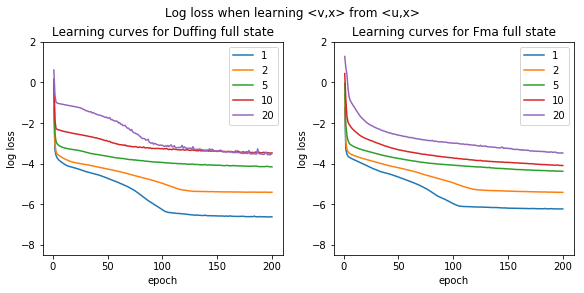

In [53]:
# Loss plot
plt.clf()
fig,axs = plt.subplots(1, len(net_list), constrained_layout=True, figsize=(len(net_list)*4, 4))
for i in range(len(net_list)):
    for n in range(len(net_list[i])):
        nn = net_list[i][n]
        losses = np.log(nn.get_loss_history())
        axs[i].plot(np.arange(1,len(losses)+1,1), losses)
    axs[i].legend(u_names)
    axs[i].set_xlabel('epoch')
    axs[i].set_ylabel('log loss')
    axs[i].set_title('Learning curves for '+sys_names[i])
    axs[i].set_ylim([-8.5,2])
fig.suptitle('Log loss when learning <v,x> from <u,x>')

## Le network_centric main loop

In [54]:
u_func_list = [
    partial(chirp, f0=0.9, f1=1.1, t1=1),
    interp1d( time1, np.random.normal(0, 0.5, time1.shape), fill_value="extrapolate", kind='cubic')
]
u_names=['chirp','rand']

In [62]:
# Set up nets
tf.keras.backend.clear_session()
seed = 2020
opt_alg = 'adam'
activation = 'tanh' # 'relu' # 'tanh'
output_activation = 'none'
log_root_dir = 'Fma_logs/'
input_mask = [2,3] # Give: u-3, v-1, x-2, t-0
Nlayer = [1,2,3,4] # 2
Nneuron = 5 # [1, 2, 5, 10, 20] # 5
de = 5
delay_int = 1

# Here, each net only trains on one input excitation function.
net_list = []
# for n in range(len(Nneuron)):
for n in range(len(Nlayer)):
    net_list_sub = []
    for j in range(len(u_func_list)):
        net_list_sub_sub = []
        for i in range(len(sys_list)):
            net_list_sub_sub.append(
                networks.NN_Delay(
                    sys_list[i], input_mask, seed=seed, log_dir=log_root_dir+sys_names[i], tensorboard=False,
    #                 Nlayer=Nlayer, Nneuron=Nneuron, activation=activation, 
#                     Nlayer=Nlayer, Nneuron=Nneuron[n], activation=activation,
                    Nlayer=Nlayer[n], Nneuron=Nneuron, activation=activation, 
                    output_activation=output_activation, optimizer=opt_alg, 
                    de=de, delay_int=delay_int
                )
            )
        net_list_sub.append(net_list_sub_sub)
    net_list.append(net_list_sub)

# Construct models
for nlist in net_list:
    for nnlist in nlist:
        for nn in nnlist:
            nn.construct()


In [63]:
# Train models. 
Epoch = 200
for n in range(len(net_list)):
    for j in range(len(net_list[n])):
        for i in range(len(net_list[n][j])):
            net_list[n][j][i].train(epoch=Epoch, inds=[j])


Train on 1996 samples
Epoch 1/200
1996/1996 [==============================] - 1s 291us/sample - loss: 0.0405
Epoch 2/200
1996/1996 [==============================] - 0s 46us/sample - loss: 0.0163
Epoch 3/200
1996/1996 [==============================] - 0s 42us/sample - loss: 0.0129
Epoch 4/200
1996/1996 [==============================] - 0s 42us/sample - loss: 0.0108
Epoch 5/200
1996/1996 [==============================] - 0s 38us/sample - loss: 0.0093
Epoch 6/200
1996/1996 [==============================] - 0s 54us/sample - loss: 0.0082
Epoch 7/200
1996/1996 [==============================] - 0s 54us/sample - loss: 0.0073
Epoch 8/200
1996/1996 [==============================] - 0s 36us/sample - loss: 0.0066
Epoch 9/200
1996/1996 [==============================] - 0s 40us/sample - loss: 0.0061
Epoch 10/200
1996/1996 [==============================] - 0s 39us/sample - loss: 0.0058
Epoch 11/200
1996/1996 [==============================] - 0s 42us/sample - loss: 0.0056
Epoch 12/200
1996/

Text(0.5, 0.98, 'Log loss over # of neurons when learning <v,x> from <u,v>')

<Figure size 432x288 with 0 Axes>

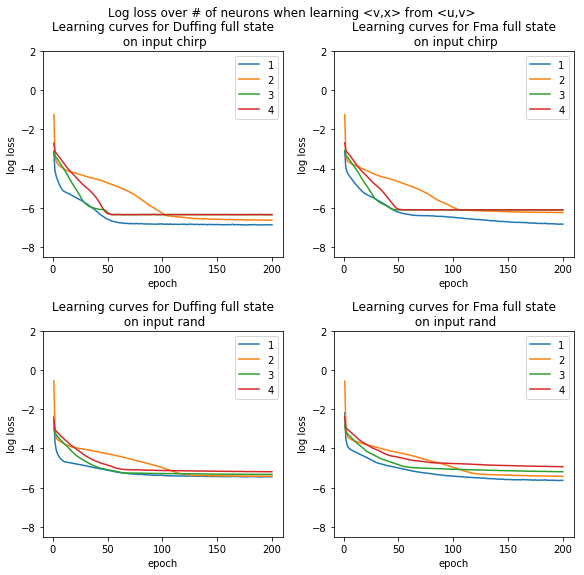

In [64]:
# Loss plot
plt.clf()
fig,axs = plt.subplots(len(net_list[0]), len(net_list[0][0]), constrained_layout=True, 
                       figsize=(len(net_list[0])*4, len(net_list[0][0])*4))

for j in range(len(net_list[0])):
    for i in range(len(net_list[0][j])):
        for n in range(len(net_list)):
            nn = net_list[n][j][i]
            losses = np.log(nn.get_loss_history())
            axs[j][i].plot(np.arange(1,len(losses)+1,1), losses)
#         axs[j][i].legend(Nneuron)
        axs[j][i].legend(Nlayer)
        axs[j][i].set_xlabel('epoch')
        axs[j][i].set_ylabel('log loss')
        axs[j][i].set_title('Learning curves for '+sys_names[i]+'\n on input '+u_names[j])
        axs[j][i].set_ylim([-8.5,2])
fig.suptitle('Log loss over # of neurons when learning <v,x> from <u,v>')

In [ ]:

# Plot systems that try to learn the full state - trajectory plot
fig, axs = plot_tests( test_inds=[0,1,2,3], net_list=net_list, net_inds=[1,2], out_list=[0,1], 
                       net_names=net_names, u_names=u_names, out_names=['v','x'],
                       datatype='traj', log_mode=False, plot_skip_rate=20, 
                       title='Delay embedding training result when given <u,v> as training input\n' )

In [ ]:
# Save models
for i in range(len(net_list)):
    net_list[i].save(net_names[i]+'-tanh-ux-models{0}'.format(i))

## Validation and testing

In [1]:
# Plotting helper function...
def plot_tests(test_inds, net_list, net_inds, out_list, net_names, u_names, out_names,
               datatype='traj', log_mode=False, plot_skip_rate=1, title=''):
    # Arguments:
    # test_inds: indices of test dataset to be plotted
    # net_list : neural nets (containing their own dynamics). Don't pass one in if its dynamics size is weird.
    # out_list : indices of output values you want to see. This assumes those indices apply to all dynamics.
    # datatype : Type of data that's going to be plotted
    # log      : whether the plots are in log scale or not
    plt.clf()
    results_list = [nn.test(inds=test_inds,squeeze=False) for nn in net_list]
    
    # datatype decides what appears on the plot
    
    Noutput = len(out_list)
    Nrow = (len(net_inds)) * Noutput # Leave the final 2 rows for aggregated plots
    Ncol = len(test_inds)
    fig,axs = plt.subplots(Nrow, Ncol, constrained_layout=True, figsize = (Ncol*4,Nrow*3), squeeze=False)
    figt,axst = plt.subplots(Noutput, Ncol, constrained_layout=True, figsize = (Ncol*4,Noutput*4), squeeze=False)
    
    for j in range(len(test_inds)):
        # For each test dataset (each column), plot all models' reactions
        jj = test_inds[j]
        
        # For each network, find its prediction and plot corresponding outputs
        for n in range(len(net_inds)):
            nn = net_inds[n]
            # Find its time series. 
            time_series = results_list[nn][2][jj][:,0,-1]
            # Above: [nn] - Take the nn-th network's result; [2] - The 3rd element in result is Inputset;
            #        [jj] - Take the jj-th test run's result; 
            #        [:,0,-1] means take all frames(:), first row (0, where we stored time), last value (-1),
            #          where we take the last value because that's where the output data matches.
            
            # Find the correct thing that we want to plot.
            if datatype == 'l2':
                result = np.square(results_list[nn][0][jj] - results_list[nn][1][jj])
            elif datatype == 'l1':
                result = np.abs(results_list[nn][0][jj] - results_list[nn][1][jj])
            # Don't need to do anything else when it's 'traj'.
            else:
                result = results_list[nn][0][jj]
            if log_mode:
                result = np.log(result)
            
            # Make individual plots for each output, where the indexing fun begins
            for i in range(Noutput):
                ii = out_list[i]
                # print(results_list[nn][1][jj].shape)
                # print(result.shape)
                make_axs_plot(
                    axs = axs[n + len(net_inds)*i][j], time = time_series, data = result[:,ii],
                    title = datatype+' of '+out_names[i]+'\n for '+net_names[nn]+'\n on input '+u_names[jj],
                    datatype = datatype, data2 = results_list[nn][1][jj][:,ii], 
                    leglist = [net_names[nn], 'True value'], skip = plot_skip_rate
                )
                #print(n + len(net_inds)*i, j, result[:,ii].shape)
                
                # Also draw this network's plot onto the overlay plots over all networks
                axst[i][j].plot(time_series[::plot_skip_rate], result[::plot_skip_rate,ii])
        
        for i in range(Noutput):
            axst[i][j].set_title( datatype+' of '+out_names[i]+'\n on input '+u_names[jj] )
            axst[i][j].legend(net_names)
    
    fig.suptitle(title)
    figt.suptitle('Overlaying result for '+title)
    return fig, axs

def make_axs_plot(axs, time, data, title, datatype, data2=None, leglist=[], skip=1):
    axs.plot(time[::skip], data[::skip])
    axs.set_title(title)
    axs.set_xlabel('t')
    if datatype == 'traj':
        axs.plot(time[::skip], data2[::skip])
        axs.legend(leglist)
    return axs



In [ ]:
# Plot systems that try to learn the full state - error plot
fig, axs = plot_tests( test_inds=[0,1,2,3], net_list=net_list, net_inds=[1,2], out_list=[0,1], 
                       net_names=net_names, u_names=u_names, out_names=['v','x'],
                       datatype='l2', log_mode=True, plot_skip_rate=20, 
                       title='Delay embedding training result errors when given <u,v> as training input\n' )